In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# ===========================================================
# 📌 2️⃣ Import libraries
# ===========================================================

import os
import glob
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# ===========================================================
# 📌 3️⃣ Get all NOISY + GT (clean) file paths recursively
# ===========================================================

# ✅ Set your base path to where your images are
base_dir = '/content/drive/MyDrive/Colab Notebooks/SIDD_Medium_Srgb/Data/'

# ✅ Grab all noisy image paths recursively
noisy_files = sorted(glob.glob(os.path.join(base_dir, '**/*NOISY_SRGB_*.PNG'), recursive=True))

# ✅ Generate the matching clean file paths
clean_files = [n.replace('NOISY_SRGB', 'GT_SRGB') for n in noisy_files]

print(f"Found {len(noisy_files)} noisy images.")
print("Example noisy:", noisy_files[0])
print("Example clean:", clean_files[0])

Found 320 noisy images.
Example noisy: /content/drive/MyDrive/Colab Notebooks/SIDD_Medium_Srgb/Data/0001_001_S6_00100_00060_3200_L/0001_NOISY_SRGB_010.PNG
Example clean: /content/drive/MyDrive/Colab Notebooks/SIDD_Medium_Srgb/Data/0001_001_S6_00100_00060_3200_L/0001_GT_SRGB_010.PNG


In [4]:
# ===========================================================
# 📌 4️⃣ Create tf.data pipeline with random patch extractor
# ===========================================================

IMG_SIZE = 128   # Patch size (can also use 256)
BATCH_SIZE = 16

def load_image_pair(noisy_path, clean_path):
  """
  Loads a noisy-clean pair, decodes PNG, converts to [0,1],
  then takes a random patch of IMG_SIZE x IMG_SIZE.
  """
  # Read noisy image
  noisy = tf.io.read_file(noisy_path)
  noisy = tf.image.decode_png(noisy, channels=3)
  noisy = tf.image.convert_image_dtype(noisy, tf.float32)

  # Read clean GT image
  clean = tf.io.read_file(clean_path)
  clean = tf.image.decode_png(clean, channels=3)
  clean = tf.image.convert_image_dtype(clean, tf.float32)

  # Stack to crop the same region for both
  stacked = tf.stack([noisy, clean], axis=0)
  cropped = tf.image.random_crop(stacked, size=[2, IMG_SIZE, IMG_SIZE, 3])

  return cropped[0], cropped[1]

# ✅ Build the dataset pipeline
dataset = tf.data.Dataset.from_tensor_slices((noisy_files, clean_files))
dataset = dataset.shuffle(1000)
dataset = dataset.map(load_image_pair, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [5]:
# -----------------------------------------------------------
# Test a batch
# -----------------------------------------------------------
for noisy_batch, clean_batch in dataset.take(1):
  print("Noisy batch shape:", noisy_batch.shape)
  print("Clean batch shape:", clean_batch.shape)

Noisy batch shape: (16, 128, 128, 3)
Clean batch shape: (16, 128, 128, 3)


In [6]:
# ===========================================================
# 📌 5️⃣ Build a simple CNN Autoencoder
# ===========================================================

from tensorflow.keras import layers, models

def build_autoencoder(input_shape=(IMG_SIZE, IMG_SIZE, 3)):
  """
  A simple convolutional autoencoder:
  Encoder: Conv2D + MaxPool
  Decoder: Conv2DTranspose + Upsampling
  """
  inputs = layers.Input(shape=input_shape)

  # Encoder
  x = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
  x = layers.MaxPooling2D(2)(x)
  x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
  x = layers.MaxPooling2D(2)(x)

  # Bottleneck
  x = layers.Conv2D(256, 3, activation='relu', padding='same')(x)

  # Decoder
  x = layers.Conv2DTranspose(128, 3, strides=2, activation='relu', padding='same')(x)
  x = layers.Conv2DTranspose(64, 3, strides=2, activation='relu', padding='same')(x)
  outputs = layers.Conv2D(3, 3, activation='sigmoid', padding='same')(x)

  return models.Model(inputs, outputs)

# ✅ Build & show summary
autoencoder = build_autoencoder()
autoencoder.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 64, 64, 128)    │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 128, 128, 64)   │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 3)    │         1,731 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 741,379 (2.83 MB)

 Trainable params: 741,379 (2.83 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# ===========================================================
# 📌 6️⃣ Compile the model
# ===========================================================

autoencoder.compile(
    optimizer='adam',
    loss='mse'
    # For a simple starter you can use MSE.
    # Later you can try SSIM or perceptual loss.
)

In [8]:
# ===========================================================
# 📌 7️⃣ Train the autoencoder
# ===========================================================

history = autoencoder.fit(dataset, epochs=20)

Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 568s 28s/step - loss: 0.0778
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 284s 14s/step - loss: 0.0288
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 323s 14s/step - loss: 0.0162
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 320s 14s/step - loss: 0.0126
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 322s 14s/step - loss: 0.0055
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 324s 14s/step - loss: 0.0049
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 322s 14s/step - loss: 0.0037
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 320s 14s/step - loss: 0.0040
Epoch 9/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 324s 14s/step - loss: 0.0031
Epoch 10/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 282s 14s/step - loss: 0.0018
Epoch 11/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 323s 14s/step - loss: 0.0018
Epoch 12/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 321s 14s/step - loss: 0.0016
Epoch 13/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 325s 14s/step - loss: 0.0014
Epoch 14/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 320s 14s/step - loss: 0.0013
Epoch 15/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 322s 14s/step - lo

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


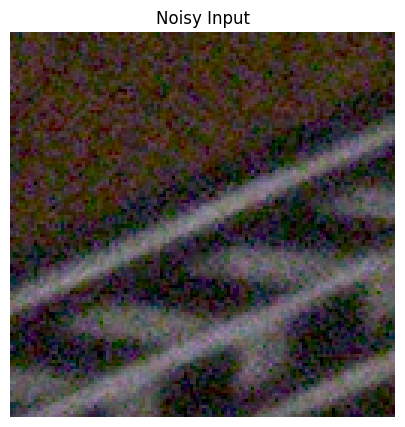

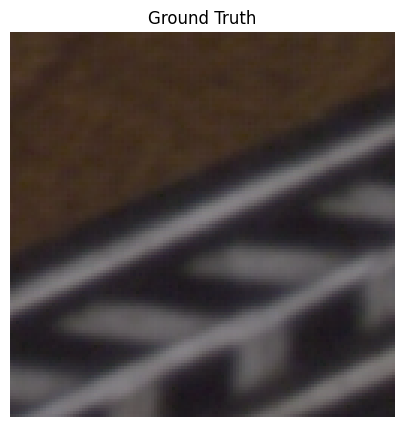

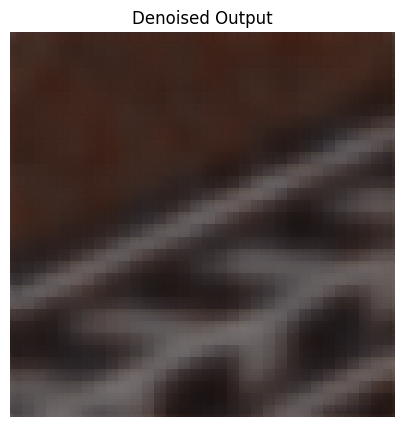

In [9]:
# ===========================================================
# 📌 8️⃣ Visualize denoising results
# ===========================================================

# Get one batch
noisy_batch, clean_batch = next(iter(dataset))

# Predict
denoised_batch = autoencoder.predict(noisy_batch)

# Plot helper
def show_image(image, title=""):
  plt.imshow(np.clip(image, 0, 1))
  plt.title(title)
  plt.axis("off")

# Plot one sample
plt.figure(figsize=(15,5))
show_image(noisy_batch[0], "Noisy Input")

plt.figure(figsize=(15,5))
show_image(clean_batch[0], "Ground Truth")

plt.figure(figsize=(15,5))
show_image(denoised_batch[0], "Denoised Output")

In [10]:
# ===========================================================
# 📌 9️⃣ Save the trained model to Drive
# ===========================================================

save_path = '/content/drive/MyDrive/Colab Notebooks/sidd_autoencoder_model.h5'
autoencoder.save(save_path)
print(f"✅ Model saved at: {save_path}")

✅ Model saved at: /content/drive/MyDrive/Colab Notebooks/sidd_autoencoder_model.h5
